In [1]:
# Main
from itertools import compress, permutations
from operator import itemgetter
import pandas as pd
import numpy as np
import random

# Support 
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import os, os.path
import requests
import datetime
import json
import time
import ast



# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display
from IPython.core.interactiveshell import InteractiveShell

In [2]:
# Get Harvard words dataset
file = 'HarvardVoc/HarvardVoc_InquirerAugmented.csv'
HarvardDF_raw = pd.read_csv(file)

# Print columns: idx/col
print("Harvard dictionary DF columns(idx/col):\n")
categories = HarvardDF_raw.columns
for a,b,c,d,e,f in zip(*[iter([((str(i+1)+" "+c)) for i,c in enumerate(categories)])]*6):
    print("{:<18}{:<18}{:<18}{:<18}{:<18}{:<18}".format(a,b,c,d,e,f))

# Explore
HarvardDF_raw.head(5)

Harvard dictionary DF columns(idx/col):

1 Entry           2 Source          3 Positiv         4 Negativ         5 Pstv            6 Affil           
7 Ngtv            8 Hostile         9 Strong          10 Power          11 Weak           12 Submit         
13 Active         14 Passive        15 Pleasur        16 Pain           17 Feel           18 Arousal        
19 EMOT           20 Virtue         21 Vice           22 Ovrst          23 Undrst         24 Academ         
25 Doctrin        26 Econ@          27 Exch           28 ECON           29 Exprsv         30 Legal          
31 Milit          32 Polit@         33 POLIT          34 Relig          35 Role           36 COLL           
37 Work           38 Ritual         39 SocRel         40 Race           41 Kin@           42 MALE           
43 Female         44 Nonadlt        45 HU             46 ANI            47 PLACE          48 Social         
49 Region         50 Route          51 Aquatic        52 Land           53 Sky         

/home/l/.conda/envs/spacy/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (63,108,109,110,176) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othrtags,Defined
0,NaN,NaN,1915,2291,1045,557,1160,833,1902,689,...,30,193,126,175,132,25,428,368,NaN,NaN
1,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some o...
2,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
3,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
4,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|


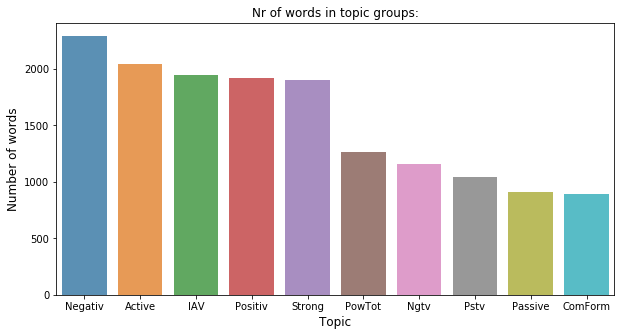

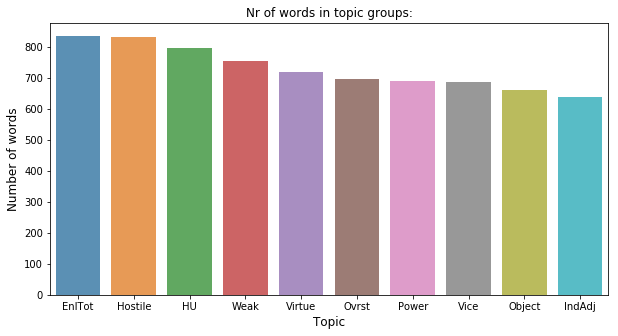

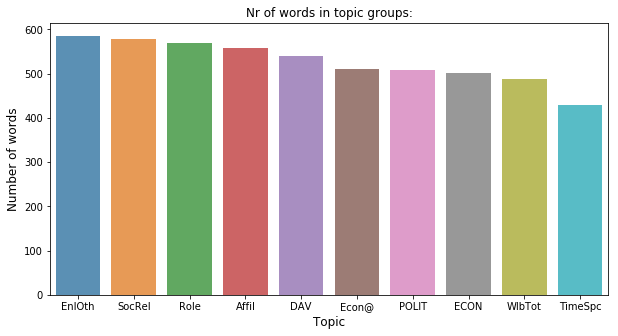

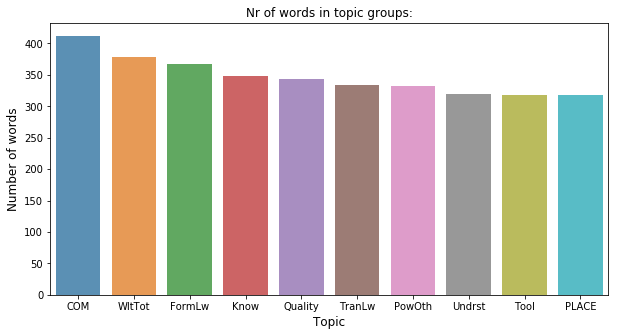

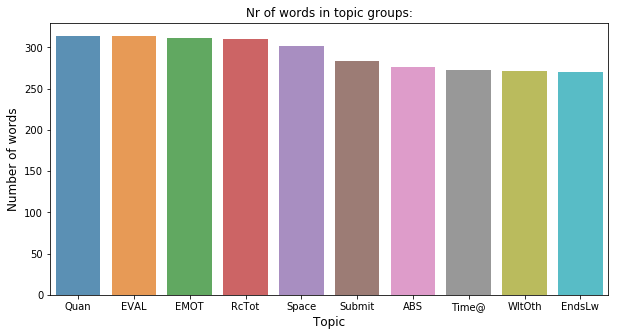

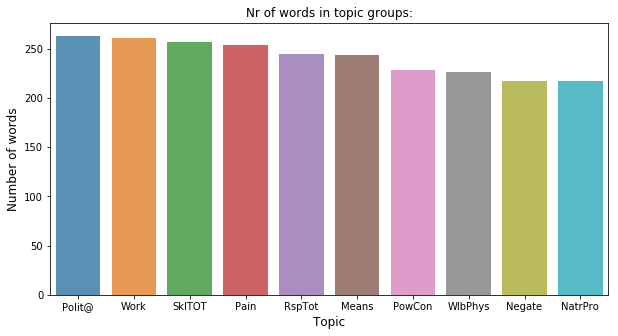

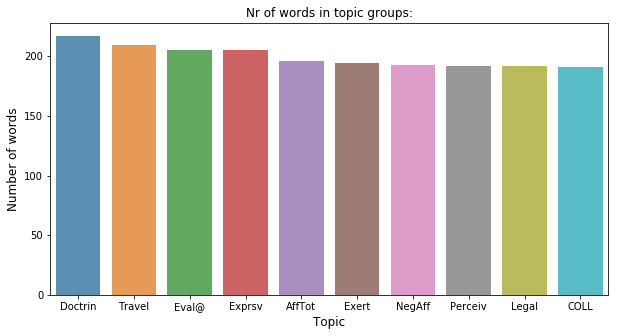

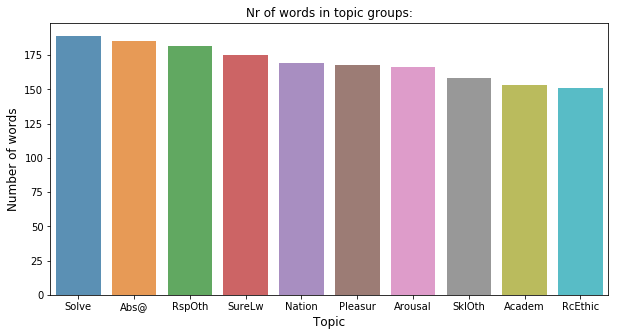

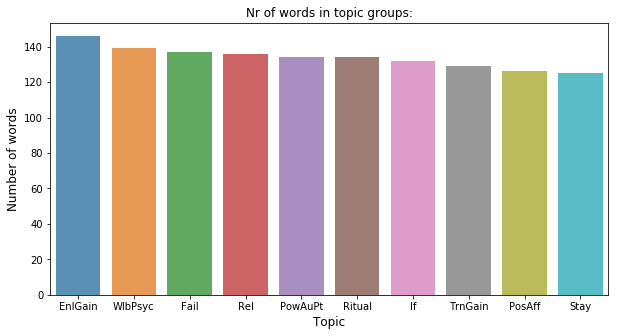

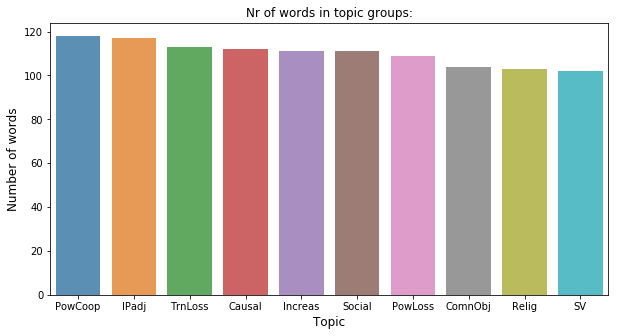

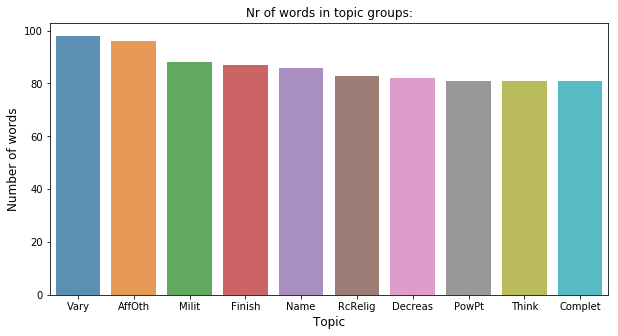

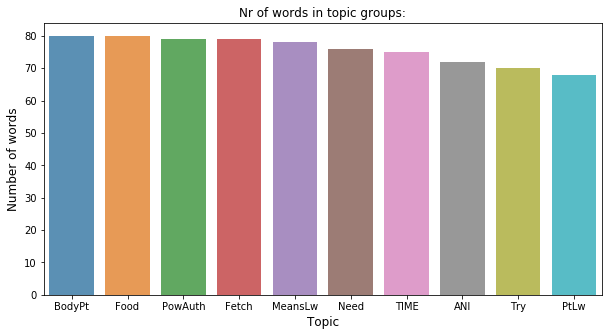

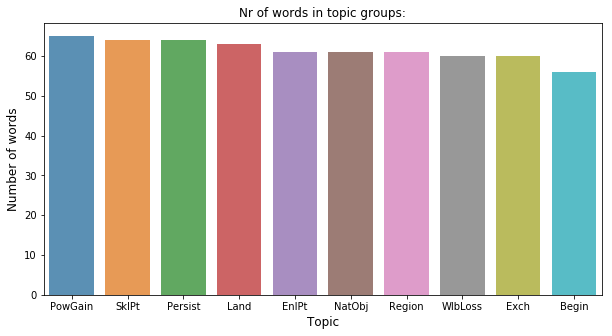

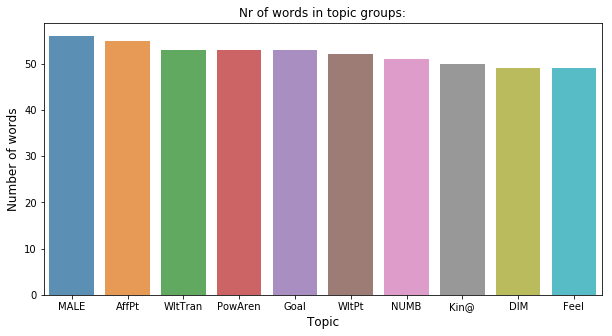

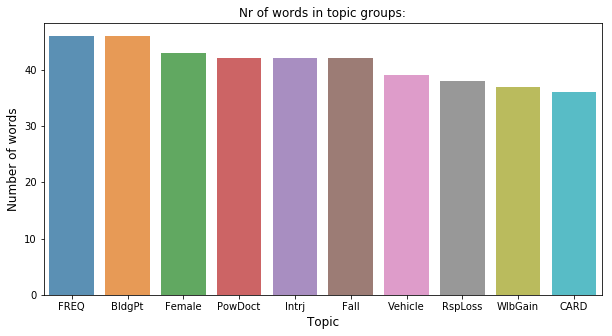

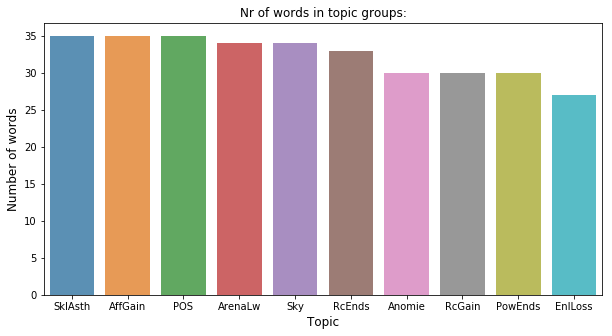

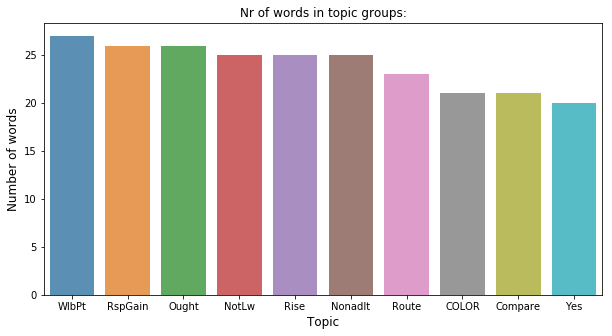

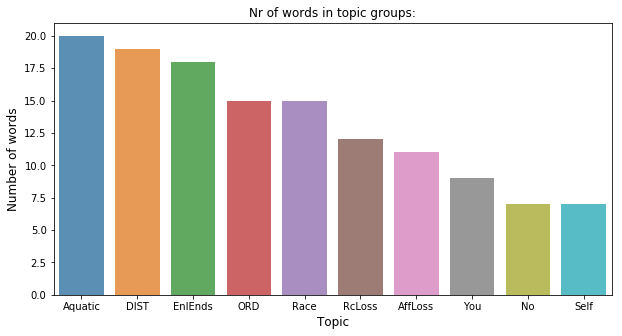

In [3]:
# Plot distribution of words in topics
# Prepare data (order:desc, groups, set x,y)
gr_of_words = list(zip(HarvardDF_raw.columns, [ int(v) for (v) in HarvardDF_raw.iloc[0,:].fillna(0).values]))
gr_of_words = sorted(gr_of_words,key=itemgetter(1))[::-1]
gr_of_words = np.split(np.asarray(gr_of_words[:180]), 18)

# Set display to plot friendly
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
time.sleep(5) # seem to need few sec to update

# Plot each group
for gr in gr_of_words:
    plt.figure(figsize=(10,5))
    plt.title('Nr of words in topic groups:')
    plt.ylabel('Number of words', fontsize=12)
    plt.xlabel('Topic', fontsize=12)
    
    topics = [x[0] for x in gr]
    nr_of_words = [int(y[1]) for y in gr]
    
    sns.barplot(topics, nr_of_words, alpha=0.8)
    plt.show()

In [4]:
# Get rich display back
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# FUN BREAK
#
# Goal: scrap the definitions of topic-word collections from Harvard
# Challange: Target website html architecture is totally mess 
#
# CAUTION: Totaly waste of time + a lot of learning:
# - python
# - text manipulation 
# - pandas
# - emotional selfcontrol  
# Rly, skip this section for your sanity. 
#
#
# Still here? 
#
# So i got 187 columns without clear definitions. Tough.
# A lot of data to understand. 
#
# I decided to play with some scrapping to get definitions of columns
# It took a bit but was fun way to and to get along with data 


# Classic MLSStripper to clean our txt a bit
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

# Script to check values on df level:
# idx = 'ECON'
# for c in ['d','n','l','t']:
#     print(c, hd[c][idx])
#     print(" ")
# for i, v in enumerate(hd["t"]):
#     if i > 100:
#         print(i, hd['t'][i])
#         print(i, len(hd['l'][i]), hd['l'][i][:4])
#         print(i, hd['n'][i])
#         print(i, hd["d"][i])
#         print(" ")

# To see what is remaining to scrap
def scrap_checkout(harvard_tags):
    remaining_cats = [cat for cat in categories if cat not in harvard_tags.keys()]
    print("Ready definitions:",len(harvard_tags.keys()))
    print("Remaining:",len(remaining_cats))
    # After char-size and "@" manipulation lets check if we got possible duplicates 
    dsum = len(remaining_cats)+len(harvard_tags.keys())
    if dsum > 186:
        alert = ' (at least ' +str(abs(dsum-186))+' too many)'
    elif dsum < 186:
        alert = ' (at least ' +str(abs(dsum-186))+' not enough)'
    else:
        alert = ''
    print("Duplicate risk is __{}__{}.\n".format((dsum != 186),alert))
    return remaining_cats


# Cook the html soup
definitions_url = 'http://www.wjh.harvard.edu/~inquirer/homecat.htm'
page = requests.get(definitions_url)
soup = BeautifulSoup(page.content, 'html.parser')
#print(soup.prettify())

# Dict to keep all data
harvard_tags = {}


# Round 1:

p_strings = []
# So i search for intresting strings in HTML: lets check 'p' at first guess
for h in soup.find_all('p'):
    h = h.text
    p_strings.append(h)
for pstr in p_strings:
    for cat in categories:
        if pstr.lower().startswith(cat.lower()):
            # It got a bit dirty here but no need to refactor it yet
            # I decided to push for speed in this task
            pstr = repr(pstr[len(cat):])[1:-1]
            pstr = pstr.strip()
            pstr = strip_tags(pstr)
            for sth in ['\n','\\n','= ','   ','  ', "'"]:
                pstr = pstr.replace(sth, '')
            if len(pstr) > 10:
                harvard_tags[cat] = pstr
                
print("+ Round 1 result:")
remaining_cats = scrap_checkout(harvard_tags)
# Output: We got ~126 categories definitions with 60 remaining to scrap 
# Not bad for a first try, and it was fun, so lets keep on rolling. 


# Round 2:

# Next guesses: 'a' or 'font' next_sibling
for a in soup.find_all('a'):
    for cat in remaining_cats:
        if cat.endswith("@"):
            cat = cat[:-1]
        if cat.lower() in str(a.text).lower():
            val = a.next_sibling
            if val:
                # I definitely could refactor this scraper 
                # as both rounds got common parts
                s = val.string
                s = strip_tags(s)
                for oth in ["'",'"',"(",")"]:
                    s = s.replace(oth, " ")
                if s.startswith(","):
                    s = s[1:]
                elif s.endswith(","):
                    s = s[:-1]
                for sth in ['\n','\\n','= ','   ','  ']:
                    s = s.replace(sth, '')
                s = s.strip()
                if len(s) > 10:
                    if cat not in harvard_tags.keys() :
                        harvard_tags[cat] = s
                        
print("+ Round 2 result:")
remaining_cats = scrap_checkout(harvard_tags)
# We got 155 more categories right after 2 rounds, 32 to go.
# Text seem really unregular full of traps (multiple use of simillar links) 
# It's tempting to scrap more but it's not worth time as we got some NN NLP to do.
# 32 definitions are easy to get other way.
# Lets get them to quickly self-made file, upload it and load to dict by a script


# Round 3

# a) It adds 28 more missing definitions directly from slightly preedited text file made from a website text.
cats_d = [c for c in HarvardDF_raw.columns if c not in harvard_tags]

lines = open("HarvardVoc/remaining_definitions.txt", "r").readlines()
for i, l in enumerate(lines):
    name = l.split(" ")[:1][0]
    if name in cats_d:
        if name not in harvard_tags:
            harvard_tags[name] = " ".join(l.split(" ")[1:])

print("+ Round 3 result:")
scrap_checkout(harvard_tags)
# So there are 5 left, it's strange, but... surprise surprise

# b) 4 of TAGS happens to not be mentioned on website so I add them manually
harvard_tags['Entry'] = ["All words. Example values in list only. Default uppercase, #\d suffix on coliding meanings."]
harvard_tags['Source']= ["Source of words. Example values in list only."] # decidet to put out for now
harvard_tags['Othrtags'] = ["229 word type tags. Example values in list only. as 'DET ART' 'SUPV' 'Noun' 'Modif' 'PREP LY' 'Modif POLIT' 'PREP' 'SUPV VERB MOD' 'Handels' 'LY' 'Noun POLIT PLACE ECON' 'SUPV PFREQ' 'Noun ECON POLIT PLACE' 'Modif PFREQ' 'Noun HU' 'Noun POLIT'"]
harvard_tags['Defined']= ["Extra definitions for a word. Example values in list only. Usually a string of text. TBH usually none."]

# c) last 1 is 'EVAL' - as it turns out it shares definition with Eval@, very simillar tag.
harvard_tags['EVAL'] = ['314 evaluative words that is used in disambiguation (broader, different category than EVAL@). Cognitive orientation (knowing, assessment, and problem solving).']

# c) And i finally decided to add other 3 tag definitions manually 
# just for sake of double protection from duplicates
harvard_tags['Eval@'] = ['205 words which imply judgment and evaluation, whether positive or negative, including means-ends judgments. Cognitive orientation (knowing, assessment, and problem solving).']
harvard_tags["Abs@"] = ['185 words reflecting tendency to use abstract vocabulary. Cognitive orientation (knowing, assessment, and problem solving).']
harvard_tags["ABS"] = ['category (276 words) used as a marker. Cognitive orientation (knowing, assessment, and problem solving).']

# d) Tidy up
harvard_tags['Econ@'] = harvard_tags.pop('Econ')
# Although there are still some mistakes left, 
# its totaly enough for now. 


print("+ Final result:")
scrap_checkout(harvard_tags)
# How nice! It's all done!

# But it turns out we got at least one duplicate. 
# As my main focus is on gathering and using text data,
# I decided for now to keep going and back here later.

# Lets copy dict just for sake of it
harvard_tags_copy = harvard_tags.copy()

+ Round 1 result:
Ready definitions: 126
Remaining: 60
Duplicate risk is __False__.

+ Round 2 result:
Ready definitions: 155
Remaining: 32
Duplicate risk is __True__ (at least 1 too many).

+ Round 3 result:
Ready definitions: 182
Remaining: 5
Duplicate risk is __True__ (at least 1 too many).



['Entry', 'Source', 'EVAL', 'Othrtags', 'Defined']

+ Final result:
Ready definitions: 186
Remaining: 0
Duplicate risk is __False__.



[]

In [6]:
# LETS PREPARE GOOD DATAFRAME TO PLAY WITH VALUES


# Build data frame out of gathered harvard_tags and reshape it:
df = pd.DataFrame(harvard_tags, index=["d"]).sort_index(axis=1)
df = df.T

# Column placeholders
df["n"] = df.index
df["l"] = df.index
df["t"] = df.index

# Columns explanation - we go for prototyping speed, so expect easy to type col names:
# 'l' as list of words
# 'n' as number of words
# 'd' as a definition of word group
# 't' as a topic of word group itself

# And pump up the display of big definitions column
df.style.set_properties(subset=['d'], **{'width': '500px'}, **{'text-align': 'left'})
#df

,d,n,l,t
ABS,"category (276 words) used as a marker. Cognitive orientation (knowing, assessment, and problem solving).",ABS,ABS,ABS
ANI,"72 references to animals,fish, birds, and insects, including theircollectivities.",ANI,ANI,ANI
Abs@,"185 words reflecting tendency to use abstract vocabulary. Cognitive orientation (knowing, assessment, and problem solving).",Abs@,Abs@,Abs@
Academ,"153 words relating to academic, intellectual or educational matters, including the names of major fields of study.",Academ,Academ,Academ
Active,2045 words implying an active orientation.,Active,Active,Active
AffGain,35 words for reaping affect.,AffGain,AffGain,AffGain
AffLoss,11 words for affect loss and indifference,AffLoss,AffLoss,AffLoss
AffOth,96 affect words not in other categories,AffOth,AffOth,AffOth
AffPt,"Affect participant, 55 words for friends and family.",AffPt,AffPt,AffPt
AffTot,196 words in the affect domain,AffTot,AffTot,AffTot


In [22]:
# Prepare final easy-to-use dataframes & save as csv files.

def hwoDF_maker(HarvardDF_raw, harvard_tags):
    hwoDF = HarvardDF_raw.iloc[1:,2:-2].notnull()
    hwoDF = pd.concat([HarvardDF_raw.iloc[1:,:1], hwoDF, HarvardDF_raw.iloc[1:,-2:]],axis=1)
    hwoDF['Entry'] = hwoDF['Entry'].str.lower()
    hwoDF["Entry"] = hwoDF["Entry"].str.replace(r"[^a-zA-Z]+", '')
    hwoDF["Entry"] = hwoDF["Entry"].str.strip()
    ok_metter = 0 
    for k, v in harvard_tags_copy.items():
        if k in hwoDF.columns:
            ok_metter += 1
        else:
            if str(k+"@") in hwoDF.columns:
                ok_metter += 1
    print("Are definitions consistent with hwoDF columns? {} -> {} vs {}.\n".format((ok_metter is len(harvard_tags_copy)), ok_metter, len(harvard_tags_copy)))
    print("Output 1 is words-only 'hwoDF' df with t/f values.")
    return hwoDF

def hd_maker(df, hwoDF, harvard_tags):
    hd = df.copy()
    # some words got '# \d' sufix
    words = hwoDF["Entry"] #.str.replace(r"[^a-zA-Z]+", '').str.lower()
    #words = [w.split("#")[0] for w in words]
    for k, v in harvard_tags_copy.items():
        if k not in ["Entry", 'Source']:
            if k in hwoDF.columns:
                bool_map = hwoDF[k].values
                apropriate_words = list(compress(words, bool_map))
                hd["l"][k] = apropriate_words
                hd["n"][k] = len(apropriate_words)
        elif k is "Entry":
            hd["l"][k] = ["Example","words","only","check","hwoDF['Entry']"]
            hd["n"][k] = len(hwoDF["Entry"].values)
        elif k is "Source":
            hd["l"][k] = ["Example","words","only","check","HarvardDF_raw['Source']"]
            hd["n"][k] = len(hwoDF["Entry"].values)  # same as "Source", not related
            
    print("Output 2 is rich 'hd' df with lists of words by topic, definitions.")
    return hd

def col_of_lists_to_csv_converter(hd):
    # Ensure all items in column are lists
    # There is, later, second part to get back strings to strings and list to lists
    for i in range(len(hd['l'])):
        if not isinstance(hd['l'][i], list):
            hd['l'][i] = list(hd['l'][i])
    return hd

# Make hwoDF and hd dataframes
hwoDF = hwoDF_maker(HarvardDF_raw, harvard_tags_copy)
hd = hd_maker(df, hwoDF, harvard_tags_copy)

# Lets save game here, save hwoDF and hd as a files:
hd = col_of_lists_to_csv_converter(hd)
hd.to_csv("HarvardVoc/harvard_dictionaries.csv", header=hd.columns)
hwoDF.to_csv("HarvardVoc/harvard_words_only.csv", header=hwoDF.columns)


# What we got now is:

# A. harvard_dictionaries.csv (file) / hd (dataframe) with:
# -- 186 words topics containing
# ---- d  definitions
# ---- n  number of words [uppercased, some with with '# \d' sufix]
# ---- l  list of words in category [from 6 to ~2200 words / topic]
# ---- t  topic name

# B. harvard_words_only.csv (file) / hwoDF (dataframe) with:
# -- 11788 english words catalogised simultaniously by 186 topic categories
# ---- col[0]    -- words col [uppercased, some with with '# \d' sufix]
# ---- col[-2]   -- speach part TAG
# ---- col[-1]   -- some words got definitions
# ---- col[1:-2] -- vals val/nan to true/false
# ---- we checked all TAG definitions (harvard_tags) to be consistent with hwoDF column names

# Lets see
display(hd.T)
display(hwoDF.head(5))

Are definitions consistent with hwoDF columns? False -> 185 vs 186.

Output 1 is words-only 'hwoDF' df with t/f values.
Output 2 is rich 'hd' df with lists of words by topic, definitions.


,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Work,Yes,You
d,category (276 words) used as a marker. Cogniti...,"72 references to animals,fish, birds, and inse...",185 words reflecting tendency to use abstract ...,"153 words relating to academic, intellectual o...",2045 words implying an active orientation.\n,35 words for reaping affect.,11 words for affect loss and indifference,96 affect words not in other categories,"Affect participant, 55 words for friends and f...",196 words in the affect domain,...,139 words connoting the psychological aspects ...,"27 roles that evoke a concern for well-being, ...",487 words in well-being domain.,"271 wealth-related words not in the above, inc...","Wealth participant, 52 words for various roles...",378 words in wealth domain.,"Wealth transaction, 53 words for pursuit of we...",of G. Semin(Univ. Sussex) and K. Fiedler (Univ...,"is 20 words directly indicating agreement, inc...",9 pronouns indicatinganother person is being a...
n,276,72,185,153,2045,35,11,96,55,196,...,139,27,487,271,52,378,53,261,20,9
l,"[ability, accuracy, action, activity, administ...","[animal, ant, badger, bat, bear, beaver, bird,...","[ability, accuracy, action, activity, advantag...","[academic, academy, art, astronomy, biological...","[abide, abolish, abscond, absolve, abuse, abus...","[affair, ask, associate, care, caress, caress,...","[abandon, alienation, alone, anger, divorce, d...","[acquaintance, affection, affectionate, allegi...","[aunt, bachelor, bride, brother, buddy, caller...","[abandon, acquaintance, affair, affection, aff...",...,"[adjust, afraid, amusement, anger, angry, angu...","[adolescent, adult, alcoholic, baby, baby, blu...","[adjust, adult, afraid, air, alcoholic, alive,...","[abundance, abundant, account, account, acre, ...","[assessor, auditor, bank, banker, broker, busi...","[abundance, abundant, account, account, acre, ...","[afford, appropriate, auction, borrow, borrow,...","[account, act, adapt, adjust, adopt, afford, a...","[absolute, agree, alright, amen, course, defin...","[thee, thou, thy, you, you, your, yours, yours..."
t,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Work,Yes,You


,Entry,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othrtags,Defined
1,a,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,DET ART,| article: Indefinite singular article--some o...
2,abandon,False,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,SUPV,|
3,abandonment,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,Noun,|
4,abate,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,SUPV,|
5,abatement,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Noun,NaN


In [17]:
#################
# END OF SCRIPT #
#################
# BELOW
# -> Reload files from cell check
# -> mini review of words in categories

In [1]:
# From now on, lets run data directly from files.
# CHECK



import pandas as pd


def csv_strlist_to_list_converter(hd):
    # pd.to_csv() convert our col of lists to strings
    # lets get back our lists and also keep some strings 
    for i in range(len(hd['l'])):
        hd['l'][i] = pd.eval(hd['l'][i])
        if len(hd['l'][i]) < 15:
            p = 0
            for nr in range (len(hd['l'][i])):
                if len(hd['l'][i][nr]) is 1:
                    p+=1
            if p > int(len(hd['l'][i])/3):
                hd['l'][i] = "".join(hd['l'][i])
    return hd

# To be refactored to take any amount and type of files
def reload_frames_from_files(clean=False):
    
    # Revive harvard words only t/f DF
    hwoDF = pd.read_csv("HarvardVoc/harvard_words_only.csv")
    hwoDF = hwoDF.iloc[:, [j for j, c in enumerate(hwoDF.columns) if j != 0]]
    hwoDF = hwoDF.set_index(hwoDF.iloc[:,0].values)
    
    # Revive hd from csv - tricky as column 'l' is of both: lists and strings
    hd = pd.read_csv("HarvardVoc/harvard_dictionaries.csv")
    hd = csv_strlist_to_list_converter(hd)
    hd = hd.set_index(hd.iloc[:,0].values)
    hd['n'] = hd['n'].astype('int')
    hd = hd.iloc[:, [j for j, c in enumerate(hd.columns) if j != 0]]
    hd = hd.T

    print("Dataframes loaded.")
    display(hd)
    display(hwoDF.head(5))
    return hd, hwoDF

# reload_libraries()
hd, hwoDF = reload_frames_from_files(False)
reload_libraries()

/home/l/.conda/envs/spacy/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Dataframes loaded.


,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Work,Yes,You
d,category (276 words) used as a marker. Cogniti...,"72 references to animals,fish, birds, and inse...",185 words reflecting tendency to use abstract ...,"153 words relating to academic, intellectual o...",2045 words implying an active orientation.\n,35 words for reaping affect.,11 words for affect loss and indifference,96 affect words not in other categories,"Affect participant, 55 words for friends and f...",196 words in the affect domain,...,139 words connoting the psychological aspects ...,"27 roles that evoke a concern for well-being, ...",487 words in well-being domain.,"271 wealth-related words not in the above, inc...","Wealth participant, 52 words for various roles...",378 words in wealth domain.,"Wealth transaction, 53 words for pursuit of we...",of G. Semin(Univ. Sussex) and K. Fiedler (Univ...,"is 20 words directly indicating agreement, inc...",9 pronouns indicatinganother person is being a...
n,276,72,185,153,2045,35,11,96,55,196,...,139,27,487,271,52,378,53,261,20,9
l,"[ability, accuracy, action, activity, administ...","[animal, ant, badger, bat, bear, beaver, bird,...","[ability, accuracy, action, activity, advantag...","[academic, academy, art, astronomy, biological...","[abide, abolish, abscond, absolve, abuse, abus...","[affair, ask, associate, care, caress, caress,...","[abandon, alienation, alone, anger, divorce, d...","[acquaintance, affection, affectionate, allegi...","[aunt, bachelor, bride, brother, buddy, caller...","[abandon, acquaintance, affair, affection, aff...",...,"[adjust, afraid, amusement, anger, angry, angu...","[adolescent, adult, alcoholic, baby, baby, blu...","[adjust, adult, afraid, air, alcoholic, alive,...","[abundance, abundant, account, account, acre, ...","[assessor, auditor, bank, banker, broker, busi...","[abundance, abundant, account, account, acre, ...","[afford, appropriate, auction, borrow, borrow,...","[account, act, adapt, adjust, adopt, afford, a...","[absolute, agree, alright, amen, course, defin...","[thee, thou, thy, you, you, your, yours, yours..."
t,ABS,ANI,Abs@,Academ,Active,AffGain,AffLoss,AffOth,AffPt,AffTot,...,WlbPsyc,WlbPt,WlbTot,WltOth,WltPt,WltTot,WltTran,Work,Yes,You


,Entry,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,...,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othrtags,Defined
a,a,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,DET ART,| article: Indefinite singular article--some o...
abandon,abandon,False,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,SUPV,|
abandonment,abandonment,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,Noun,|
abate,abate,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,SUPV,|
abatement,abatement,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Noun,NaN


Libraries loaded


In [11]:
# Exploration of words and types

def rdm(l, n):
    return random.sample(l, n)

def explore_hd(hd, display_size=5):
    cols = [col for col in hd.columns if col not in ['Entry', 'Source']]
    for k in rdm(list(cols), len(cols)):
        
        title = hd[k]['t']
        print("{}".format(title))
        
        words_collection = hd[k]['l']
        n_words = hd[k]['n']
        size = display_size
        if n_words < display_size:
            size = n_words - 1
        random_words = rdm(list(words_collection), size)
        # Title for nicer display 
        words = [word.title() for word in random_words]
        #words = random_words
        wide = 6
        if (wide < len(words)):
            for a,b,c,d,e,f in zip(*[iter([((c)) for i,c in enumerate(words)])]*wide):
                print("{:<18}{:<18}{:<18}{:<18}{:<18}{:<18}".format(a,b,c,d,e,f))
#                 n += wide
#             if len(words) > n:
#                 print("(also:"," ".join(words[-(len(words) % wide):]))              
        else:
            print("Examples:", ", ".join(words))
        print("def: {}..\n".format(hd[k]['d'][:-1]))

display_size = 24
explore_hd(hd, display_size)

TrnLoss
Shut              Ruin              Deprivation       Kill              Strike            Limit             
Knife             Lack              Hit               Shot              Murder            Fall              
Struck            Tear              Devise            Kill              Turn              Destruct          
Interrupt         Upset             Undid             Separation        Deprive           Trouble           
def: Transaction loss, 113 general words of not accomplishing, buthaving setbacks instead..

Pstv
Firmness          Acceptable        Independent       Appoint           Nice              Learner           
Saint             Capability        Colleague         Gleam             Celebration       Devote            
Pretty            Give              Train             Profit            Virtuous          Civilization      
Legitimate        Competent         Hit               Loyalty           Convince          Decent            
def: 1045 positive wor

Our
Examples: Lets, Ours, Our, We, Us
def: 6 pronouns referring tothe inclusive self ("we", etc...

Causal
Guilty            Necessarily       Effect            Lead              Consequent        Impossible        
Reason            Impetus           Deliberate        Accidental        Likely            Obtainable        
Why               Give              Stimulate         Thank             Prediction        Manageable        
Account           Why               Viability         Stimulation       Offender          Chance            
def: 112 words denoting presumption that occurrence of one phenomenonis necessarily preceded, accompanied or followed by the occurrenceof another..

RcEnds
Goddess           Bless             Principle         Discipline        Persevere         Creator           
Heaven            God               Ritual            Principle         Maxim             Faith             
Bless             Pray              Discipline        Perseverance      Customary  

In [15]:
# GET Harvard Dictionary (hd) word lists as JSON 
import json

# Get dict
HDD = {}

for each in hd.columns:
    HDD[each] = hd.loc['l'][each]
    
# Save to JS
DIR = "HarvardVoc/"
HHD_file = DIR + 'HDD.json'

with open(HHD_file, "w") as f:
    json.dump(HDD, f, indent=4)